In [2]:
from google.colab import files
uploaded = files.upload()


Saving train_FD003.txt to train_FD003.txt


In [3]:
import pandas as pd

# Set file name
filename = 'train_FD003.txt'  # or 'train_FD004.txt'

# Column names
columns = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f's{i}' for i in range(1, 22)]

# Load and clean
df = pd.read_csv(filename, sep=' ', header=None)
df.dropna(axis=1, inplace=True)
df.columns = columns

df.head()


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [4]:
rul_df = df.groupby('unit')['cycle'].max().reset_index()
rul_df.columns = ['unit', 'max_cycle']
df = df.merge(rul_df, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select only sensor columns (ignore op settings if needed)
sensor_cols = [f's{i}' for i in range(1, 22)]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [6]:
import numpy as np

def generate_sequences(data, sequence_length=50):
    X, y = [], []
    for unit in data['unit'].unique():
        unit_df = data[data['unit'] == unit]
        for i in range(len(unit_df) - sequence_length):
            seq = unit_df.iloc[i:i+sequence_length][sensor_cols].values
            label = unit_df.iloc[i+sequence_length]['RUL']
            X.append(seq)
            y.append(label)
    return np.array(X), np.array(y)

X, y = generate_sequences(df)


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X, y, epochs=20, batch_size=200, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - loss: 20194.3477 - val_loss: 19950.6113
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - loss: 18575.2051 - val_loss: 19046.6699
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - loss: 17782.5410 - val_loss: 18249.3516
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - loss: 16690.5664 - val_loss: 17515.1328
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - loss: 16483.8223 - val_loss: 16788.8535
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step - loss: 15545.9707 - val_loss: 16127.2480
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - loss: 14539.6270 - val_loss: 15506.8857
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 295ms/step - loss: 14293.1309 - val_loss: 14929.0156
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - loss: 13661.0566 - val_loss: 14387.6543
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - loss: 13075.6289 - val_loss: 13883.1270
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/

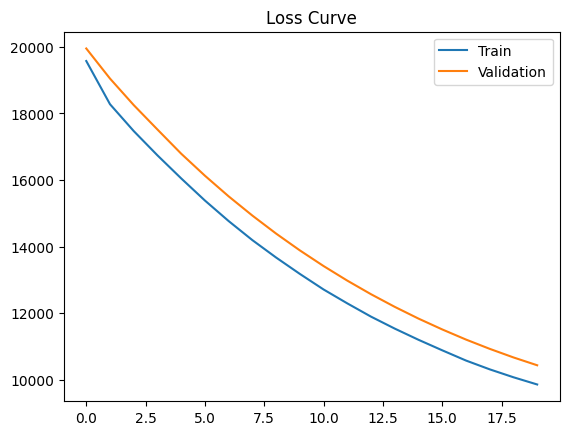

617/617 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step


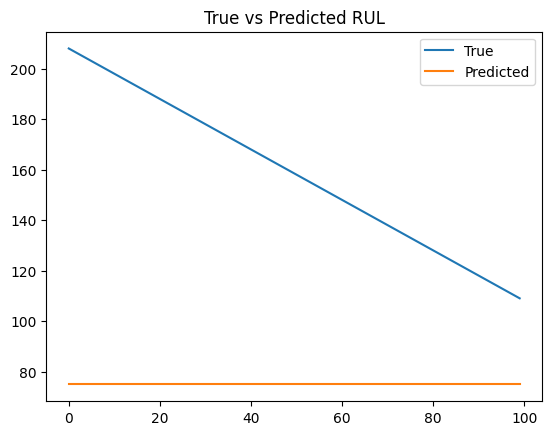

In [8]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title("Loss Curve")
plt.show()

# Predict
y_pred = model.predict(X)

plt.plot(y[:100], label='True')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.title("True vs Predicted RUL")
plt.show()


In [9]:
model.save('fd003_rul_model.h5')  # or 'fd004_rul_model.h5'
